In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [ ]:
# 입력 파이프라인 설정하기
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete3CHPBR/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete3CHPBR/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete3CHPBR/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [ ]:
encoder = info.features['text'].encoder

In [ ]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [ ]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [ ]:
assert original_string == sample_string

In [ ]:
for index in encoded_string:
  print ('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

In [ ]:
# 모델 만들기
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
#   Keras 모델을 컴파일하여 훈련 프로세스 구성하기
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
# 모델 훈련하기
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 52s 108ms/step - loss: 0.6475 - accuracy: 0.5664 - val_loss: 0.5120 - val_accuracy: 0.7630
Epoch 2/10
391/391 [==============================] - 43s 107ms/step - loss: 0.3619 - accuracy: 0.8432 - val_loss: 0.3433 - val_accuracy: 0.8536
Epoch 3/10
391/391 [==============================] - 43s 108ms/step - loss: 0.2572 - accuracy: 0.8997 - val_loss: 0.3320 - val_accuracy: 0.8651
Epoch 4/10
391/391 [==============================] - 43s 109ms/step - loss: 0.2102 - accuracy: 0.9209 - val_loss: 0.3290 - val_accuracy: 0.8651
Epoch 5/10
391/391 [==============================] - 43s 109ms/step - loss: 0.1825 - accuracy: 0.9348 - val_loss: 0.3865 - val_accuracy: 0.8687
Epoch 6/10
391/391 [==============================] - 43s 108ms/step - loss: 0.1643 - accuracy: 0.9414 - val_loss: 0.3698 - val_accuracy: 0.8724
Epoch 7/10
391/391 [==============================] - 42s 107ms/step - loss: 0.1450 - accuracy: 0.9505 - val_loss: 0.3898 - val_ac

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________




---



# IMDB 영화평 텍스트 분석 Model 테스트

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 16s 42ms/step - loss: 0.4411 - accuracy: 0.8528
Test Loss: 0.44108444452285767
Test Accuracy: 0.8528000116348267


In [ ]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [ ]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [ ]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.20030783]]


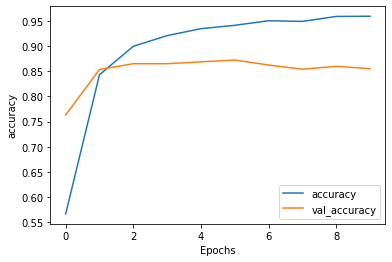

In [ ]:
plot_graphs(history, 'accuracy')

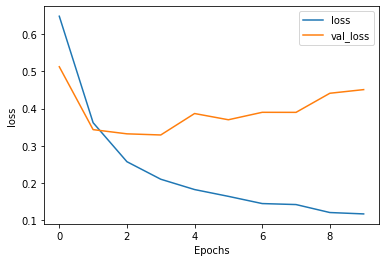

In [ ]:
plot_graphs(history, 'loss')



---
# IMDB 영화평 텍스트 분석 Model 강화하기
### *두 개 이상의 LSTM 레이어 쌓기*


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 80s 192ms/step - loss: 0.6634 - accuracy: 0.5406 - val_loss: 0.5159 - val_accuracy: 0.7771
Epoch 2/10
391/391 [==============================] - 75s 190ms/step - loss: 0.3776 - accuracy: 0.8432 - val_loss: 0.3448 - val_accuracy: 0.8542
Epoch 3/10
391/391 [==============================] - 75s 189ms/step - loss: 0.2642 - accuracy: 0.9037 - val_loss: 0.3362 - val_accuracy: 0.8620
Epoch 4/10
391/391 [==============================] - 74s 188ms/step - loss: 0.2119 - accuracy: 0.9272 - val_loss: 0.3698 - val_accuracy: 0.8573
Epoch 5/10
391/391 [==============================] - 74s 188ms/step - loss: 0.1718 - accuracy: 0.9455 - val_loss: 0.3857 - val_accuracy: 0.8552
Epoch 6/10
391/391 [==============================] - 74s 189ms/step - loss: 0.1472 - accuracy: 0.9556 - val_loss: 0.4263 - val_accuracy: 0.8646
Epoch 7/10
391/391 [==============================] - 74s 188ms/step - loss: 0.1244 - accuracy: 0.9638 - val_loss: 0.4512 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 31s 80ms/step - loss: 0.5987 - accuracy: 0.8440
Test Loss: 0.59870845079422
Test Accuracy: 0.8439599871635437


In [ ]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-3.2668567]]


In [ ]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-4.792295]]
